In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# 評価

> Test

In [ ]:
#|default_exp Comp

In [ ]:
#| hide
#| export
import numpy as np
import jax.numpy as jnp
import jax.random as jrd
import jax
from jaxtyping import Float, Int, Array, PRNGKeyArray
from KalmanPaper import gen, EKF, VA, Exper
from matplotlib import pyplot as plt
from typing import Tuple
from functools import partial

In [ ]:
#| export
@partial(jax.jit, static_argnames=['N', 'T'])
def RMS(
    key: PRNGKeyArray,
    N: int,
    T: int,
    G: Float[Array, "{N} {N}"],
    w0: Float[Array, "{N}"],
    Sigma: Float[Array, "{N} {N}"],
    P0: Float[Array, "{N} {N}"], 
    propy1: Float
):
  X, Y, W, (Wtt_EKF, Ptt_EKF), (Wtt_VA, Ptt_VA, Xit_VA) \
    = Exper.exper(key, N, T, G, w0, Sigma, P0, propy1)
  W_norm = jnp.sqrt(jnp.sum(W**2, axis=1))
  RMS_Wtt_EKF = jnp.sqrt(jnp.sum((W - Wtt_EKF)**2, axis=1)) # shape: (T:)
  RMS_Wtt_VA = jnp.sqrt(jnp.sum((W - Wtt_VA)**2, axis=1))
  
  return W_norm, RMS_Wtt_EKF, RMS_Wtt_VA

In [ ]:
G = jnp.array([[1/2**6, 0], [0, 1/2**6]], dtype=jnp.float32)
Sigma = jnp.array([[0.5, 0], [0, 0.5]], dtype=jnp.float32)
w0 = jnp.array([1,1], dtype=jnp.float32)
propy1 = 0.5

W_norm, RMS_Wtt_EKF, RMS_Wtt_VA = RMS(
  key=jrd.PRNGKey(0), 
  N=2, 
  T=1000, 
  G=G,
  w0=w0,
  Sigma=Sigma,
  P0=G,
  propy1=propy1)

<matplotlib.legend.Legend>

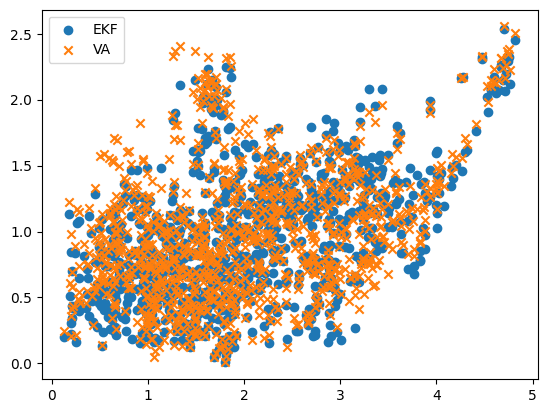

In [ ]:
plt.scatter(W_norm, RMS_Wtt_EKF, label="EKF")
plt.scatter(W_norm, RMS_Wtt_VA, marker='x', label="VA")
plt.legend()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()